# An extremely short `Convex.jl` tutorial

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\argmin}{{\text{argmin}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\E}{\mathbf{E}}
\newcommand{\var}{\mathbf{var}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$


__<div style="text-align: right"> EE787: Machine learning, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_

## What is `Convex.jl`?

`Convex.jl` is a Julia package for Disciplined Convex Programming (DCP). `Convex.jl` makes it easy to describe optimization problems in a natural, mathematical syntax, and to solve those problems using a variety of different (commercial and open-source) solvers. 
It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

The code below solves a simple optimization problem in `Convex.jl`:


In [1]:
using Convex, SCS

# Create two scalar optimization variables.
x = Variable()
y = Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = sumsquares(x - y)
# Form and solve problem.
prob = minimize(obj, constraints)
solve!(prob, SCSSolver())
println("status: $(prob.status)")
println("optimal value: $(prob.optval)")
println("optimal var: x_opt=$(evaluate(x)), y_opt=$(evaluate(y))")

status: Optimal
optimal value: 0.9999999866266575
optimal var: x_opt=0.9999999991919287, y_opt=3.3126433563060806e-9
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 12, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 5, constraints m = 9
Cones:	primal zero / dual free vars: 2
	linear vars: 2
	soc vars: 5, soc blks: 2
Setup time: 3.86e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.41e+19  1.77e+19  1.00e+00 -5.44e+19  1.07e+19  2.56e+19  1.87e-05 
    

The status, which was assigned a value “optimal” by the solve method, tells us the problem was solved successfully. The optimal value (basically 1 here) is the minimum value of the objective over all choices of variables that satisfy the constraints. The last thing printed gives values of x and y (basically 1 and 0 respectively) that achieve the optimal objective.

`solve!(prob)` returns the optimal value and updates `prob.status`, `prob.optval`, and the `evaluate()` field of all the variables in the problem.



----------------------------
<br>

## Example: least squares

In [2]:
# Solves a bounded least-squares problem.

using Convex, SCS
using Random

# Problem data.
m = 10
n = 5
Random.seed!(787)
A = randn(m, n)
b = randn(m)

# Construct the problem.
x = Variable(n)
objective = sumsquares(A*x - b)
constraints = [0 <= x, x <= 1]
prob = minimize(objective, constraints)
solve!(prob, SCSSolver())

println("Optimal value: ", prob.optval)
println("Optimal var")
println(evaluate(x)) # A numpy ndarray.


Optimal value: 5.702754934035449
Optimal var
[2.85387e-8; 0.0344284; 3.54109e-8; 0.198559; 0.529573]
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 66, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 8, constraints m = 26
Cones:	primal zero / dual free vars: 1
	linear vars: 11
	soc vars: 14, soc blks: 2
Setup time: 2.12e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.44e+19  3.49e+19  1.00e+00 -1.26e+20  4.68e+19  3.69e+19  1.74e-05 
    60| 5.47e-08 

----------------------------
<br>

## Example: LASSO

Computing trade-off curves is a common use of parameters. The example below computes a trade-off curve for a LASSO problem.

\begin{align*}
    \underset{x}{\minimize} \quad & \|Ax-b\|_2^2 + \gamma\|x\|_1
\end{align*}

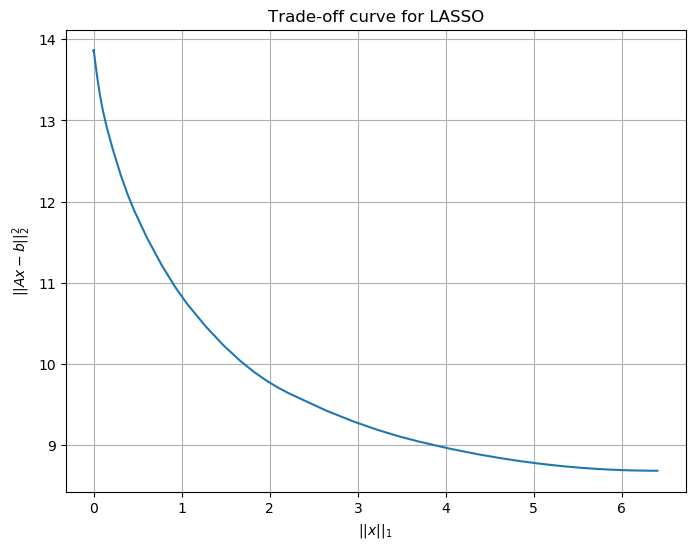

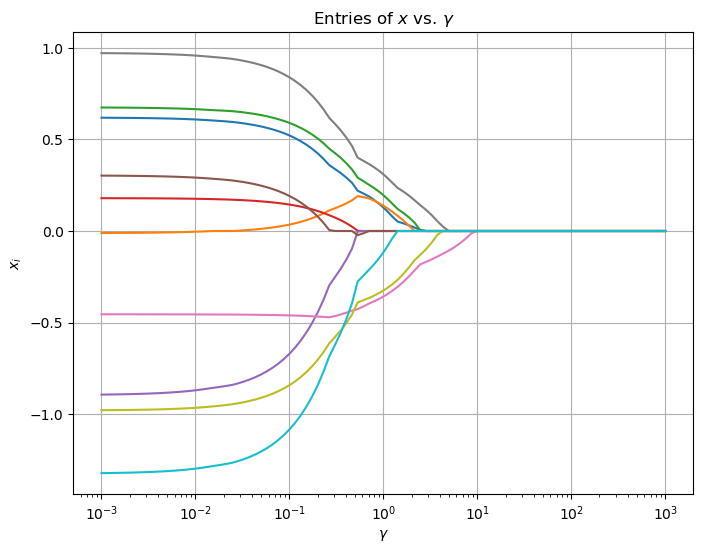

In [3]:
using LinearAlgebra, Random, PyPlot
using Convex, ECOS

# Problem data
n = 15
m = 10
Random.seed!(787)
A = randn(n, m)
b = randn(n)

# Construct the problem
x = Variable(m)
loss = sumsquares(A*x - b)
reg = norm(x,1)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
K = 100
gamma_vals = exp10.(range(-3,stop=3,length=K))
sq_penalty = zeros(K)
l1_penalty = zeros(K)
x_values = zeros(m,K)

for k in range(1,stop=K)
    gamma = gamma_vals[k]
    obj = loss + gamma*reg
    prob = minimize(obj)
    solve!(prob, ECOSSolver(verbose=false))
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty[k] = evaluate(loss)[1]
    l1_penalty[k] = evaluate(reg)[1]
    x_values[:,k] = evaluate(x)[:,1]
end

# Plot trade-off curve
figure(figsize=(8,6), dpi=100)
plot(l1_penalty, sq_penalty)
xlabel(L"$||x||_1$")
ylabel(L"$||Ax-b||_2^2$")
grid()
title("Trade-off curve for LASSO")
show()

# Plot entries of x vs. gamma
figure(figsize=(8,6), dpi=100)
for i in range(1, stop=m)
    semilogx(gamma_vals, x_values[i,:])
end
xlabel(L"$\gamma$")
ylabel(L"$x_{i}$")
grid()
title(L"Entries of $x$ vs. $\gamma$")
show()

----------------------------
<br>

## Example: Tykhonov regularization

Similar but different results with the sum_squares regularizer are shown below.

\begin{align*}
    \underset{x}{\minimize} \quad & \|Ax-b\|_2^2 + \gamma\|x\|_2^2
\end{align*}

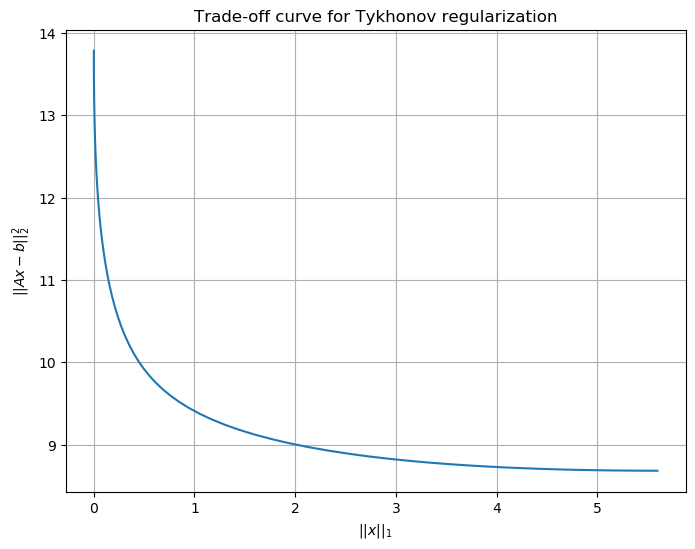

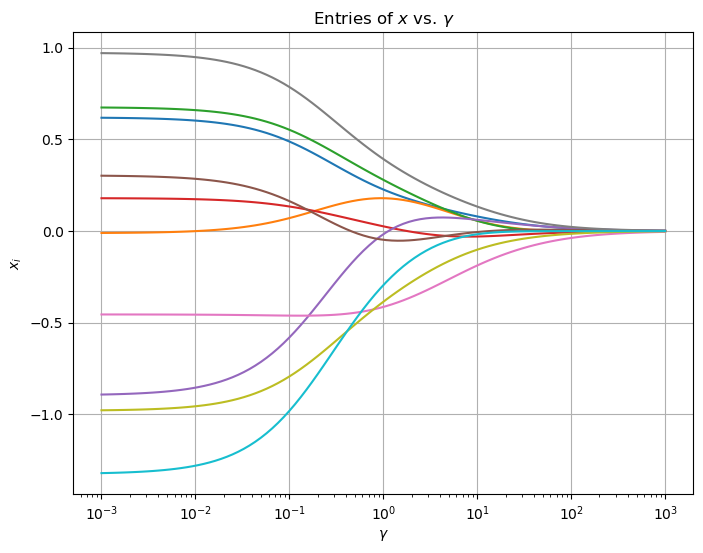

In [4]:
using LinearAlgebra, Random, PyPlot
using Convex, ECOS

# Problem data
n = 15
m = 10
Random.seed!(787)
A = randn(n, m)
b = randn(n)

# Construct the problem
x = Variable(m)
loss = sumsquares(A*x - b)
reg = sumsquares(x)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||^2
K = 100
gamma_vals = exp10.(range(-3,stop=3,length=K))
sq_penalty = zeros(K)
l1_penalty = zeros(K)
x_values = zeros(m,K)

for k in range(1,stop=K)
    gamma = gamma_vals[k]
    obj = loss + gamma*reg
    prob = minimize(obj)
    solve!(prob, ECOSSolver(verbose=false))
    sq_penalty[k] = evaluate(loss)[1]
    l1_penalty[k] = evaluate(reg)[1]
    x_values[:,k] = evaluate(x)[:,1]
end

# Plot trade-off curve
figure(figsize=(8,6), dpi=100)
plot(l1_penalty, sq_penalty)
xlabel(L"$||x||_1$")
ylabel(L"$||Ax-b||_2^2$")
grid()
title("Trade-off curve for Tykhonov regularization")
show()

# Plot entries of x vs. gamma
figure(figsize=(8,6), dpi=100)
for i in range(1, stop=m)
    semilogx(gamma_vals, x_values[i,:])
end
xlabel(L"$\gamma$")
ylabel(L"$x_{i}$")
grid()
title(L"Entries of $x$ vs. $\gamma$")
show()

---
_<div style="text-align: right"> Refer to Convex.jl tutorial pages at https://www.juliaopt.org/Convex.jl/stable/quick_tutorial/ <div>_

